In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

import matplotlib.pyplot as plt  # Import matplotlib's pyplot module

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    def policy_fn(observation):
        best_action = np.argmax(Q[observation])
        # Create a probability vector with all zeros except for the best action
        action_probabilities = np.zeros(len(Q[observation]))
        action_probabilities[best_action] = 1.0
        return action_probabilities
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for _ in range(num_episodes):
        state = env.reset()
        episode = []
        while True:
            action_probabilities = behavior_policy(state)
            action = np.random.choice(np.arange(len(action_probabilities)), p=action_probabilities)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        G = 0.0
        W = 1.0
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            Q[state][action] = Q[state][action] + (W / sum(behavior_policy(state)) * (G - Q[state][action]))
            if action != np.argmax(Q[state]):
                break
            W = W / behavior_policy(state)[action]
    
    target_policy = create_greedy_policy(Q)
    
    return Q, target_policy


In [7]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=50000, behavior_policy=random_policy)

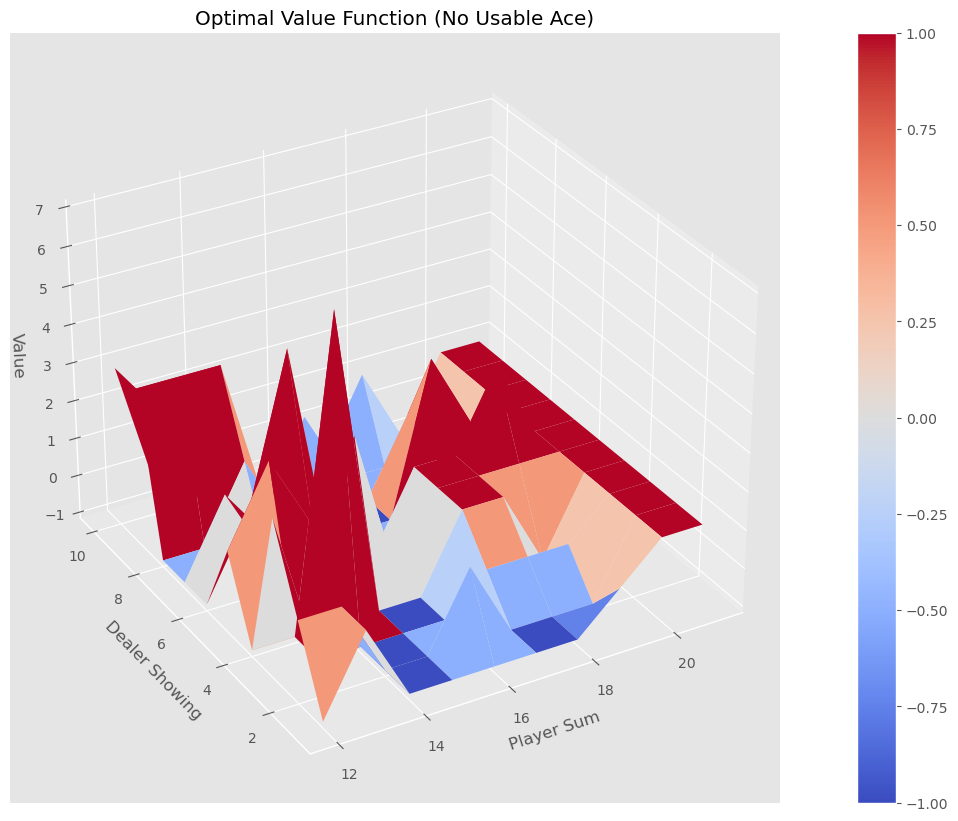

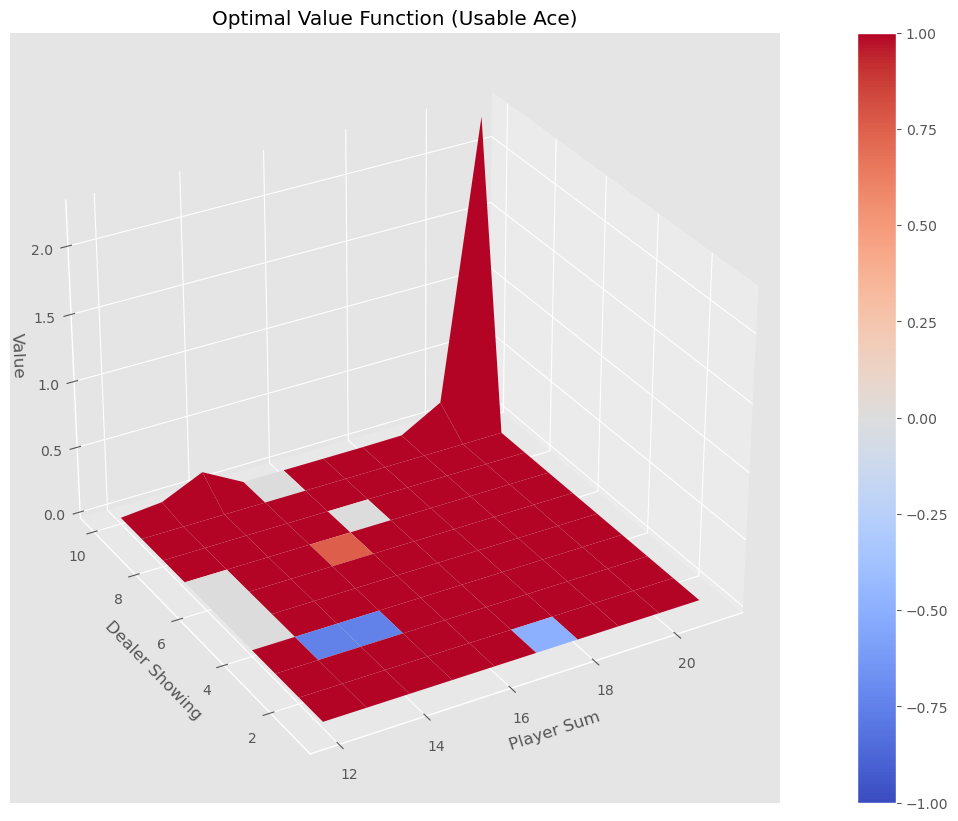

In [8]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value

plotting.plot_value_function(V, title="Optimal Value Function")